In [1]:
print("Hello World")

Hello World


In [2]:
import numpy as np
import matplotlib.pyplot as plt   
import pickle as pkl
from atasi import AtasiNet    
import os 
from pathlib import Path

In [3]:

WORK_DIR = os.path.join('../', Path().resolve())
DATA_DIR = os.path.join(WORK_DIR, 'Simulated_data')

fc = 14.25e9 #Hz
lambda_c = 0.021 #m
delta_D = 0.084 #m
R0 = 400 #m
theta = 45*np.pi/180 #rad
n_antennas = 8 #number of antennas

n_grids = 200 #number of grids (of different height cells)
rayleigh_res = lambda_c*R0/(2*delta_D) #Rayleigh resolution, 50m in this case 

run_W = False #run the W matrix calculation

rewrite_sim_data = False #rewrite the simulated data
n_samples_training = 10000 #number of samples
n_samples_testing = 1000 #number of samples

In [4]:
def generate_backscatter_coefficients(height=None):
	if height == None : 
		height = np.random.choice([k for k in range(n_grids)])
	A = min(max(np.abs(np.random.rayleigh(scale=2, size=1)[0]), 1), 4)

	phi = np.random.uniform(0, 2 * np.pi, size=1)[0]
	gamma_ = A * np.exp(1j * phi)
	gamma = np.zeros(n_grids,dtype=complex)
	gamma[height] = gamma_
	return gamma

#referred to as A in the model implementation part
def compute_measurement_matrix():
	s = np.linspace(0, n_grids,n_grids) 
	#baselines in gamma-net go from -135 to 135 in 25 steps 
	baselines = np.linspace (-135,135,25)
	D = np.exp(1j * 4 * np.pi * np.outer(baselines, s) / (lambda_c * R0))
	return D

def simulate_backscattered_signal(signal, D):
    return np.dot(D, signal)

def double_scatterer(height1,height2):
	gamma1 = generate_backscatter_coefficients(height1)
	gamma2 = generate_backscatter_coefficients(height2)
	gamma = gamma1 + gamma2 
	return [gamma,gamma1,gamma2]

def SNR(signal, noise):
	"""Computes the SNR of a signal
		inputs : 
			signal : the signal
			noise : the noise
		outputs :
			snr : the SNR of the signal
	"""
	signal_power = np.sum(np.abs(signal)**2)
	noise_power = np.sum(np.abs(noise)**2)
	snr = 10 * np.log10(signal_power / noise_power)
	return snr

def noise_for_snr(signal, snr):
	"""Adds the right amount of noise to the signal to reach the desired SNR 
		inputs : 
			signal : the signal to which the noise will be added
			snr : the desired SNR
		outputs :
			noisy_signal : the signal with added noise
	"""
	noise = np.random.normal(0, 1, signal.shape)
	signal_power = np.sum(np.abs(signal)**2)
	noise_power = np.sum(np.abs(noise)**2)
	noise = noise * np.sqrt(signal_power / (10**(snr/10) * noise_power))
	noisy_signal = signal + noise
	return noisy_signal

def generate_gamma(n_scatterers,height=None,scatterers_dist=None) :
	if n_scatterers == 2:

		#no height and resolution specified : generate random heights
		if height == None and scatterers_dist == None :
			height1 = np.random.choice([k for k in range(n_grids)])
			height2 = np.random.choice([k for k in range(n_grids)])
			while height1 == height2:
				height2 = np.random.choice([k for k in range(n_grids)])

		#no height specified but resolution specified : generate random heights with a given distance
		elif height == None and scatterers_dist is not None :
			height1 = np.random.choice([k for k in range(n_grids)])
			height2 = height1 + scatterers_dist 
			if height2 >= n_grids : 
				height2 = height1 - scatterers_dist
		
		#height specified
		else : 
			height1 = height[0]
			height2 = height[1]

		return double_scatterer(height1,height2)
	
	elif n_scatterers == 1 : 
		if height is not None and type(height) != int : 
			raise TypeError("If only one scatterer, height must be an integer")
		elif height is None : 
			height = np.random.choice([k for k in range(n_grids)])
		return [generate_backscatter_coefficients(height)]
	
	else : 
		raise ValueError("Number of scatterers must be one or two")
	
#if storage becomes an issue, we can change the way we store the data to avoid storing so many zeros
def generate_data(n_samples,save=False,names=None,test_set=False):
	if test_set : 
		snr_values = np.array([30]) #just one R at 30 dB
	else :
		snr_values = np.linspace(0,30,11) #SNR values from 0 to 30 dB
	D = compute_measurement_matrix()
	n_sub_sample = n_samples//snr_values.shape[0]

	#generate single scatterers' data
	single_scatterers = np.zeros((snr_values.shape[0],n_sub_sample), dtype=dict)
	for snr in snr_values : 
		snr_index = np.where(snr_values == snr)[0][0]
		for i in range(n_samples//snr_values.shape[0]):
			gamma = generate_gamma(1)[0]
			signal = simulate_backscattered_signal(gamma, D)
			noisy_signal = noise_for_snr(signal, snr)
			#with gamma's modulus you can get A, with its phase you can get phi, with its index you can get the height
			#all the labels are in gamma
			data = {'signal':noisy_signal, 'gamma':gamma} 
			single_scatterers[snr_index,i] = data

	#generate double scatterers' data
	double_scatterers = np.zeros((snr_values.shape[0],n_sub_sample), dtype=dict)
	for snr in snr_values : 
		snr_index = np.where(snr_values == snr)[0][0]
		for i in range(n_samples//snr_values.shape[0]):
			scatterers_gap = int(np.random.uniform(0.1, 1.2) * rayleigh_res)
			gamma,gamma1,gamma2 = generate_gamma(2,scatterers_dist=scatterers_gap)
			signal = simulate_backscattered_signal(gamma, D)
			noisy_signal = noise_for_snr(signal, snr)
			data = {'signal':noisy_signal, 'gamma':gamma, 'gamma1':gamma1, 'gamma2':gamma2, 'scatterers_gap':scatterers_gap} 
			double_scatterers[snr_index,i] = data

	single_scatterers = single_scatterers.reshape(-1)
	double_scatterers = double_scatterers.reshape(-1)

	if save :
		if names is None :
			names = ['single_scatterers','double_scatterers']
		np.save(os.path.join(DATA_DIR,names[0]), single_scatterers)
		np.save(os.path.join(DATA_DIR,names[1]), double_scatterers)
		
	return single_scatterers, double_scatterers


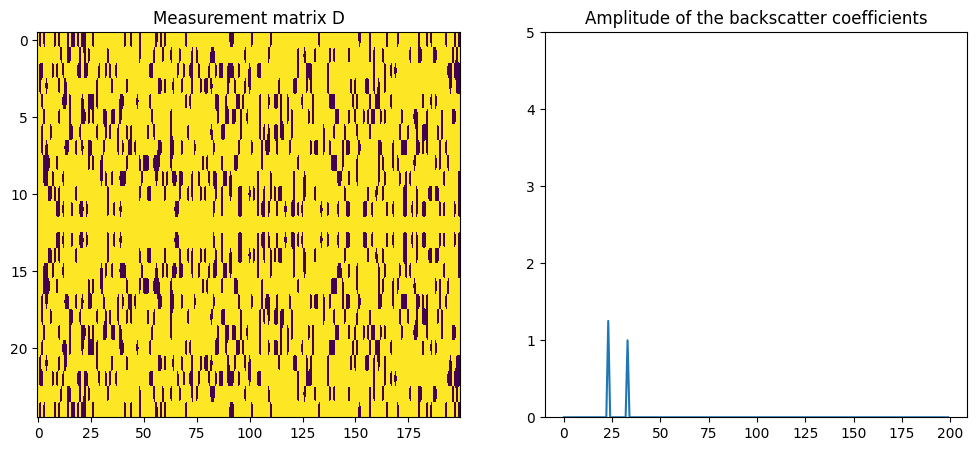

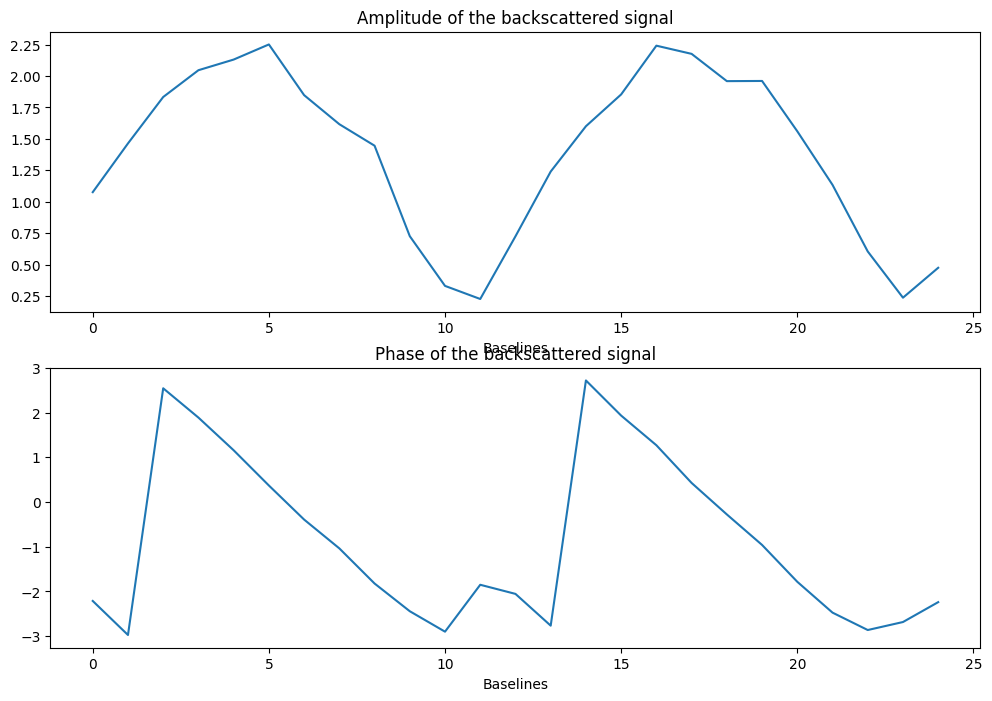

In [5]:
target_snr = 20
n_scatterers = 2
distancing_factor = 0.2 #between 0.1 and 1.2 (times the rayleigh resolution)

gamma = generate_gamma(n_scatterers,scatterers_dist=int(rayleigh_res*distancing_factor))[0]

f,axes = plt.subplots(1,2,figsize=(12,5))
axes[1].plot([np.abs(gamma[k]) for k in range(len(gamma))])
axes[1].set_title("Amplitude of the backscatter coefficients")
axes[1].set_ylim(0, 5)

D = compute_measurement_matrix()
axes[0].imshow(np.abs(D),aspect='auto')
axes[0].set_title("Measurement matrix D")
plt.show()

signal = noise_for_snr(gamma, target_snr)
y = simulate_backscattered_signal(signal,D)

f,axes = plt.subplots(2,1,figsize=(12,8))
axes[0].plot([np.abs(y[k]) for k in range(len(y))])
axes[1].plot([np.angle(y[k]) for k in range(len(y))])
axes[0].set_title("Amplitude of the backscattered signal")
axes[0].set_xlabel("Baselines")
axes[1].set_title("Phase of the backscattered signal")
axes[1].set_xlabel("Baselines")
plt.show()

#### Pre-compute W and generate the data

In [6]:
if run_W:
	model = AtasiNet(D)
	W = model.compute_w()
	# print(W.shape)
	# print(D.shape)
	score = np.linalg.norm(W.T@D)**2
	print("Final score : ",score)
	pkl.dump(model, open("./Models/model_", "wb"))


In [7]:
#generate the training data
if rewrite_sim_data :
	_ = generate_data(n_samples= n_samples_training ,
					save=True,
					names= ['single_scatterers_train','double_scatterers_train'],
					test_set=False)

In [8]:
#generate the testing data
if rewrite_sim_data :
	_ = generate_data(n_samples= n_samples_testing ,
					save=True,
					names=['single_scatterers_test','double_scatterers_test'],
					test_set=True)

Text(0.5, 1.0, 'Measurement matrix D')

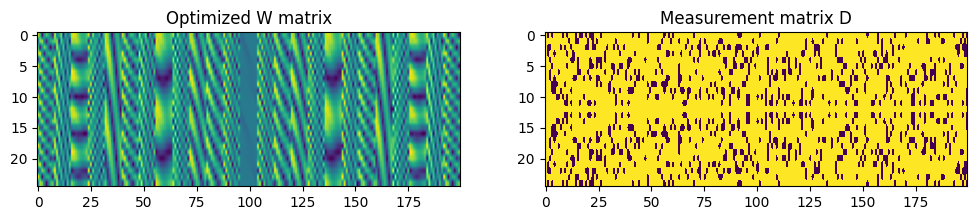

In [9]:
model_bis = pkl.load(open(os.path.join(WORK_DIR,'Models/model_W_optimized.pkl'), "rb"))
W = model_bis.W
figure,axes = plt.subplots(1,2,figsize=(12,2))
axes[0].imshow(np.abs(W), aspect='auto')
axes[0].set_title("Optimized W matrix")
axes[1].imshow(np.abs(D), aspect='auto')
axes[1].set_title("Measurement matrix D")

#### Run the training of the model on the generated dataset

In [10]:
#load the data 
single_scatterers_train_loaded = np.load(os.path.join(DATA_DIR,'single_scatterers_train.npy'), allow_pickle=True)
double_scatterers_train_loaded = np.load(os.path.join(DATA_DIR,'double_scatterers_train.npy'), allow_pickle=True)
single_scatterers_test_loaded = np.load(os.path.join(DATA_DIR,'single_scatterers_test.npy'), allow_pickle=True)
double_scatterers_test_loaded = np.load(os.path.join(DATA_DIR,'double_scatterers_test.npy'), allow_pickle=True)

scatterers_train_loaded = np.concatenate((single_scatterers_train_loaded,double_scatterers_train_loaded))
scatterers_test_loaded = np.concatenate((single_scatterers_test_loaded,double_scatterers_test_loaded))

In [11]:
#shuffle train set and split it into train and validation
n_train = int(0.9*len(scatterers_train_loaded))
n_val = int(0.1*len(scatterers_train_loaded))
np.random.shuffle(scatterers_train_loaded)
np.random.shuffle(scatterers_test_loaded)

scatterers_train = scatterers_train_loaded[:n_train]
scatterers_val = scatterers_train_loaded[n_train:]
scatterers_test = scatterers_test_loaded

#extract the signals and the labels
signals_train = np.array([scatterers_train[i]['signal'] for i in range(len(scatterers_train))])
signals_val = np.array([scatterers_val[i]['signal'] for i in range(len(scatterers_val))])
signals_test = np.array([scatterers_test[i]['signal'] for i in range(len(scatterers_test))])
                    
labels_train = np.array([scatterers_train[i]['gamma'] for i in range(len(scatterers_train))])
labels_val = np.array([scatterers_val[i]['gamma'] for i in range(len(scatterers_val))])
labels_test = np.array([scatterers_test[i]['gamma'] for i in range(len(scatterers_test))])

print(f"{len(signals_train)} training samples, {len(signals_val)} validation samples, {len(signals_test)} testing samples")


17998 training samples, 2000 validation samples, 2000 testing samples


In [12]:
#Use scikit to preprocess the data
#Use only the module, else the code automatically rejects the imaginary part 
#This is maybe not ideal, since we loose the phase information

from sklearn.preprocessing import StandardScaler

signals_train = np.abs(signals_train)
signals_val = np.abs(signals_val)
signals_test = np.abs(signals_test)

scaler = StandardScaler()
scaler.fit(signals_train)
signals_train = scaler.transform(signals_train)
signals_val = scaler.transform(signals_val)
signals_test = scaler.transform(signals_test)


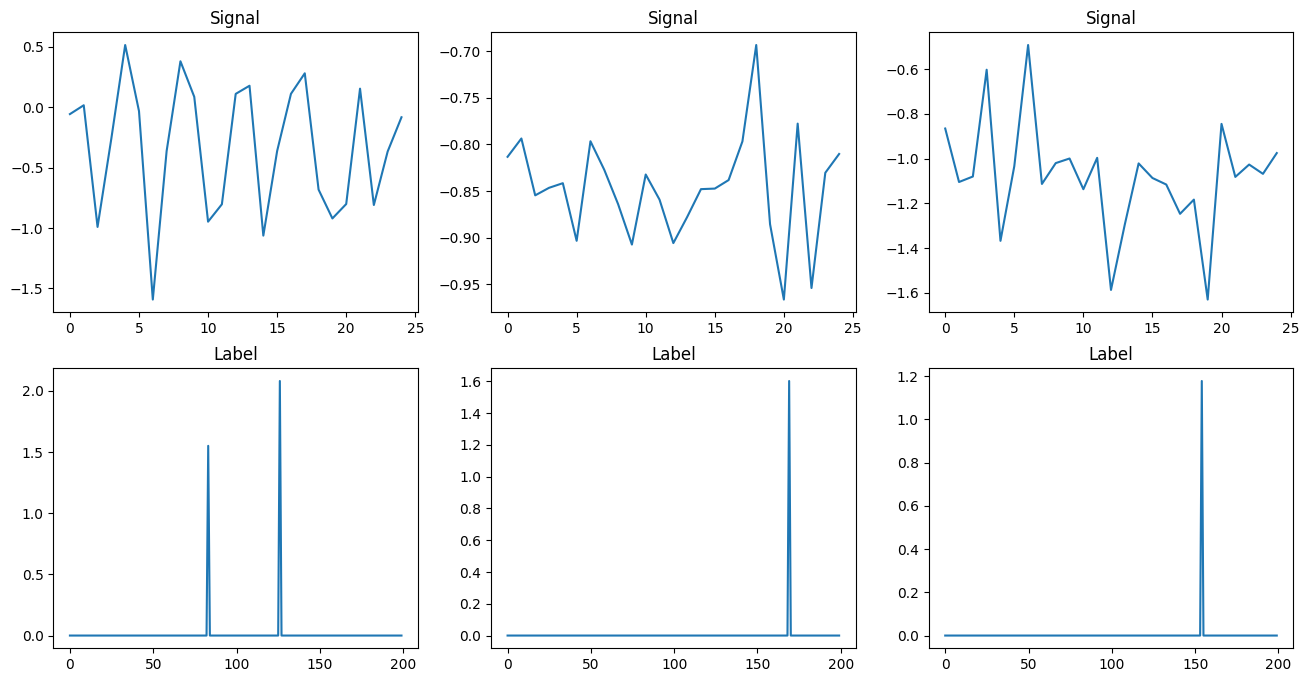

In [13]:
#check the data is correct by plotting some random ones
f,axes = plt.subplots(2,3,figsize=(16,8))
for i in range(3):
    index = np.random.randint(0,len(signals_train))
    axes[0,i].plot(signals_train[index])
    axes[0,i].set_title("Signal")
    axes[1,i].plot(np.abs(labels_train[index]))
    axes[1,i].set_title("Label")

#### Actual training loop

In [14]:
atasi_model = AtasiNet(D,K=10,W=W)
atasi_model.train(signals_train, labels_train,epochs=10,learning_rate=0.001)

c:\Users\isaya\Documents\Coding\IMA\IMA_206\IMA206_project\Isaya_Impl\atasi.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  gamma_k[i] = self.eta_threshold(z_i, theta_k_i)
c:\Users\isaya\Documents\Coding\IMA\IMA_206\IMA206_project\Isaya_Impl\atasi.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  grad_mu[k] = np.sum((gamma_k - gamma_label) * (gamma_k - mu[k])) / (np.abs(gamma_k - gamma_label).sum() + 1e-5)
c:\Users\isaya\Documents\Coding\IMA\IMA_206\IMA206_project\Isaya_Impl\atasi.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  grad_beta[k] = np.sum((gamma_k - gamma_label) * (gamma_k - beta[k])) / (np.abs(gamma_k - gamma_label).sum() + 1e-5)


Epoch 1/10, Loss: 2.3762, Mu: [0.09995103 0.09995103 0.09995103 0.09995103 0.09995103 0.09995103
 0.09995103 0.09995103 0.09995103 0.09995103], Beta: [0.0099951 0.0099951 0.0099951 0.0099951 0.0099951 0.0099951 0.0099951
 0.0099951 0.0099951 0.0099951]
Epoch 2/10, Loss: 2.3762, Mu: [0.09990208 0.09990208 0.09990208 0.09990208 0.09990208 0.09990208
 0.09990208 0.09990208 0.09990208 0.09990208], Beta: [0.00999021 0.00999021 0.00999021 0.00999021 0.00999021 0.00999021
 0.00999021 0.00999021 0.00999021 0.00999021]


KeyboardInterrupt: 

cristiano.ulondumendes@telecom-paris.fr